In [1]:
import ipywidgets as ipw
from IPython.display import display
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import json

from stochastic_models import AntimonyModel
from stochastic_tests import Test
import sim_lib


def model_string(num_variables: int, rate_cf: float):
    if num_variables < 2:
        raise ValueError('Must use two or more variables')
    
    model_string_expressions = [f'->V{i} ; sin(a * time);' for i in range(num_variables)]
    model_string = '\n'.join(model_string_expressions)
    
    model_string_params = [f'a = {rate_cf};']
    model_string += '\n'.join([''] + model_string_params)
    
    return model_string, [f'V{i}' for i in range(num_variables)], ['a']


rate = 0.1
stdev_cf = 0.25
model_sizes = [2, 3, 4, 5, 10]

t_fin = 50.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   trials=[100, 1000, 10000], 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)],
                   stochastic=False)

tests = []
tests_ms, tests_var_names, tests_param_names = [], [], []
for model_size in model_sizes:
    ms, var_names, param_names = model_string(model_size, rate)
    tests.append(Test(model=AntimonyModel(ms, var_names, param_dists={param_names[0]: ('norm', (rate, rate * stdev_cf))}), **test_kwargs))
    tests_ms.append(ms)
    tests_var_names.append(var_names)
    tests_param_names.append(param_names)

_ = sim_lib.start_pool()

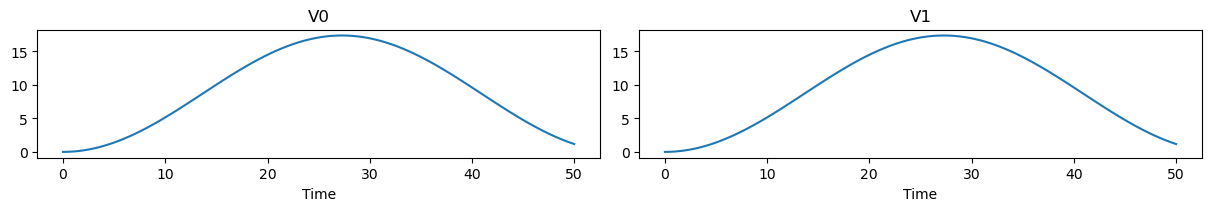

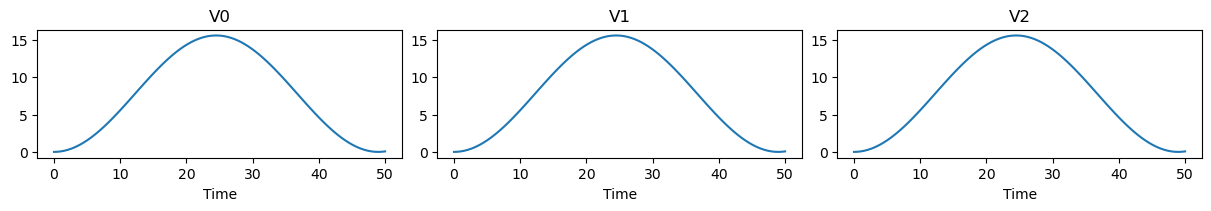

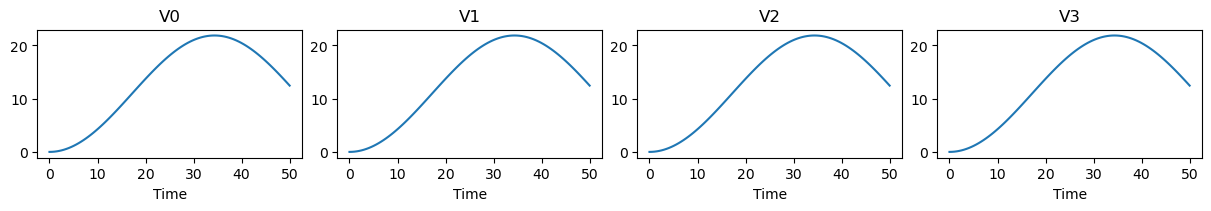

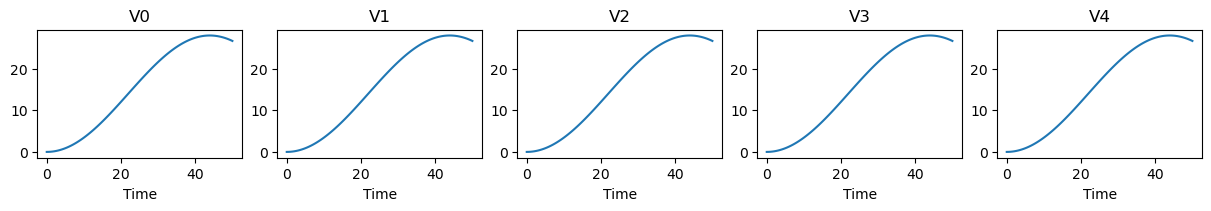

In [2]:
[test.execute_deterministic() for test in tests]
for i, test in enumerate(tests):
    test.execute_deterministic()
    if model_sizes[i] <= 5:
        _ = test.plot_results_deterministic()

In [3]:
label, label_header, out = ipw.Label(), ipw.Label(), ipw.Output()
display(out)
with out:
    display(label_header)
    display(label)

for i, test in enumerate(tests):
    label_header.value = f'Test {i+1}...'
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

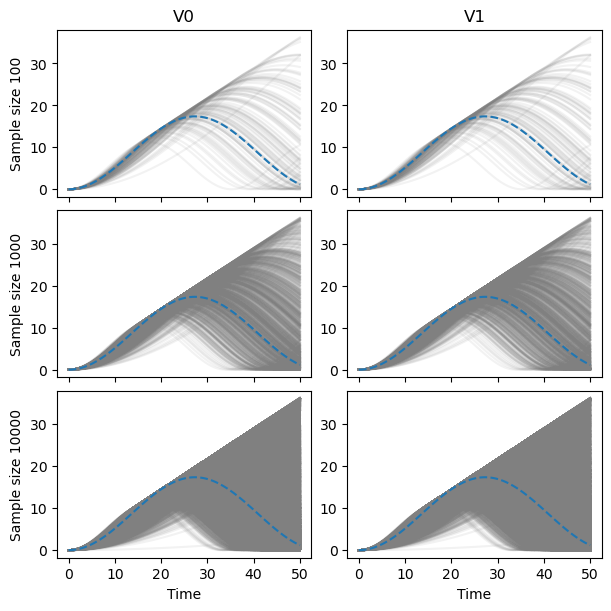

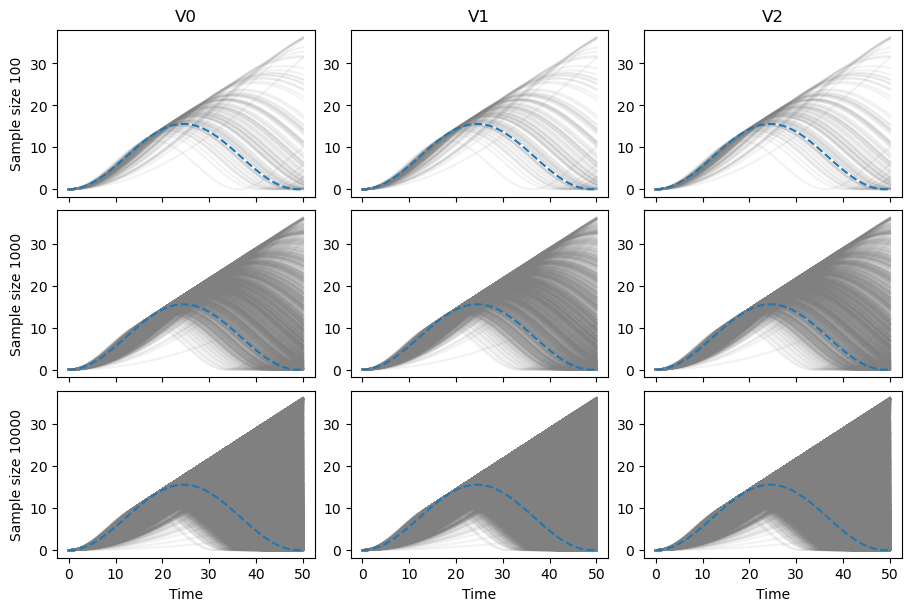

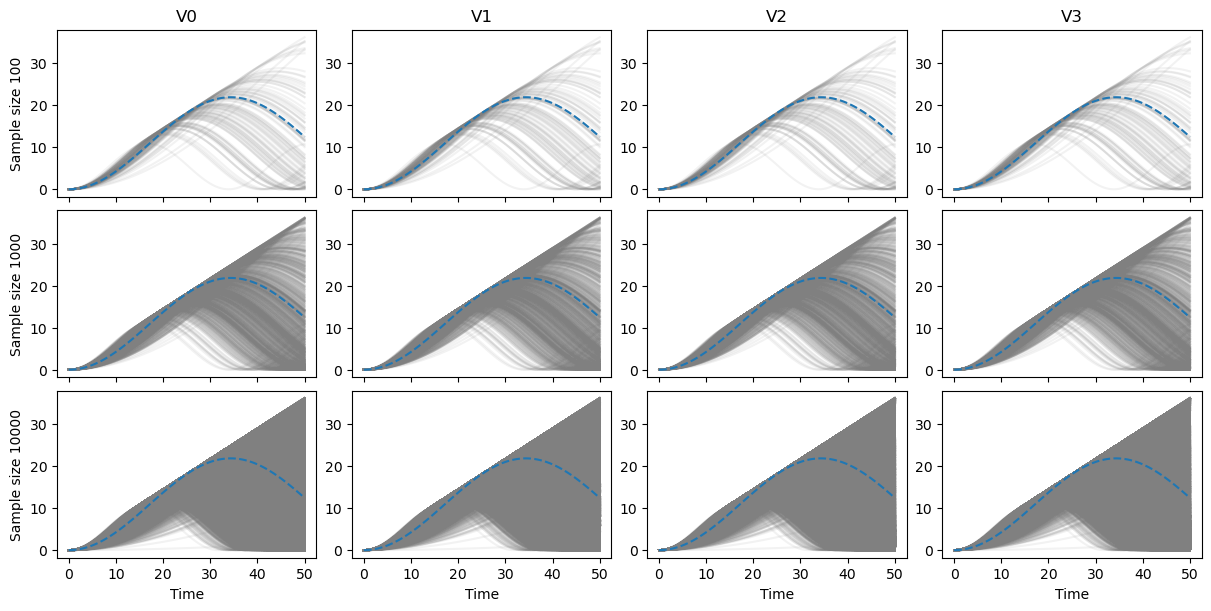

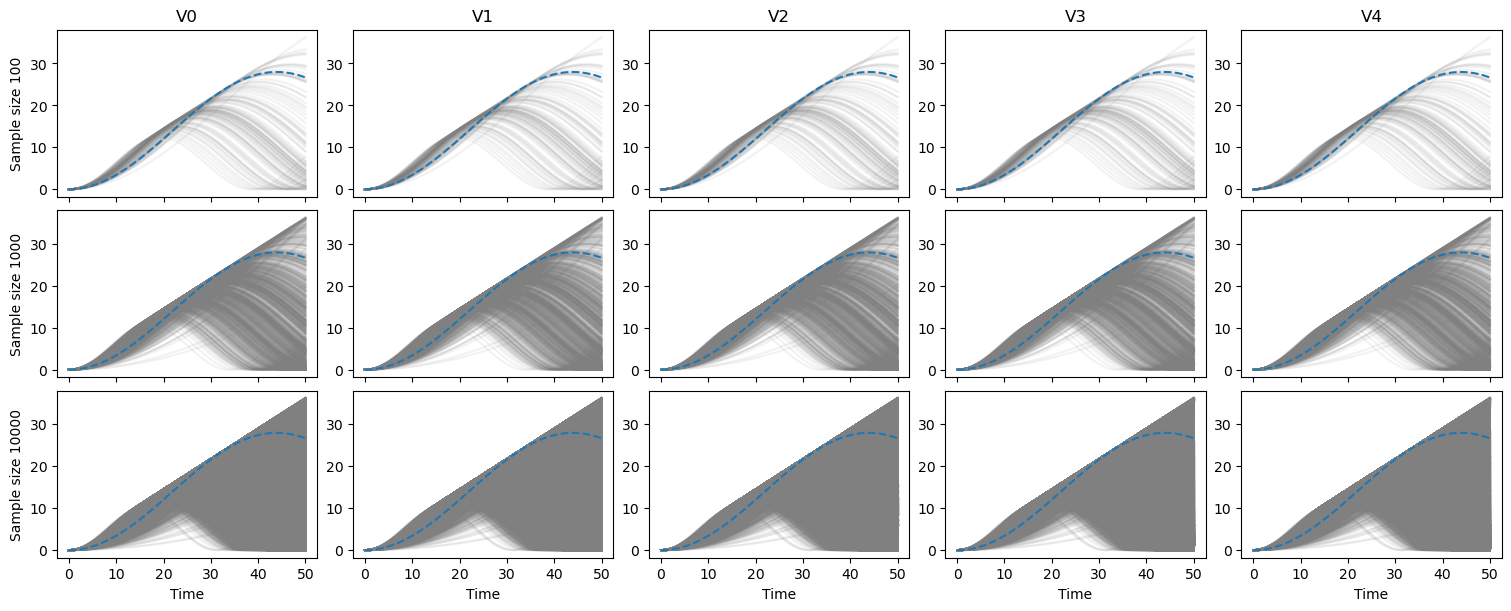

In [4]:
for i, test in enumerate(tests):
    if model_sizes[i] <= 5:
        _ = test.plot_results_stochastic()

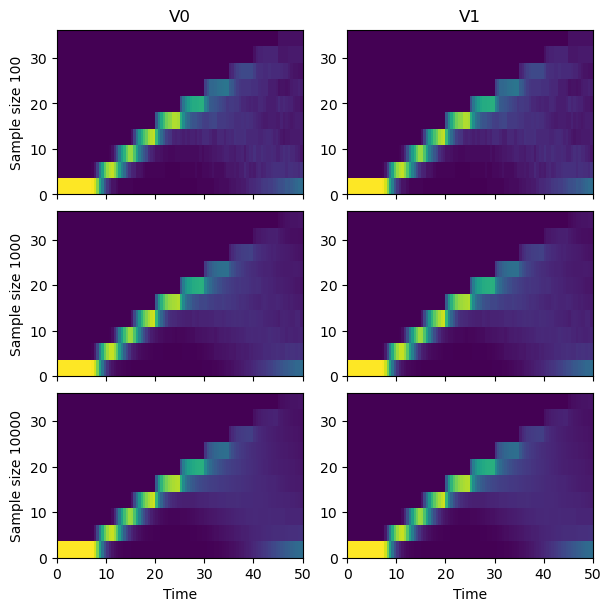

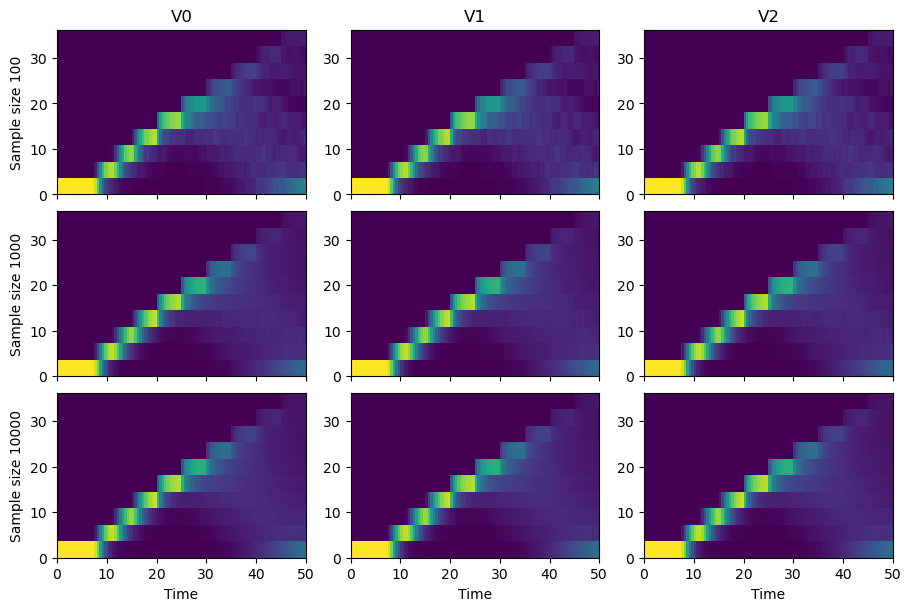

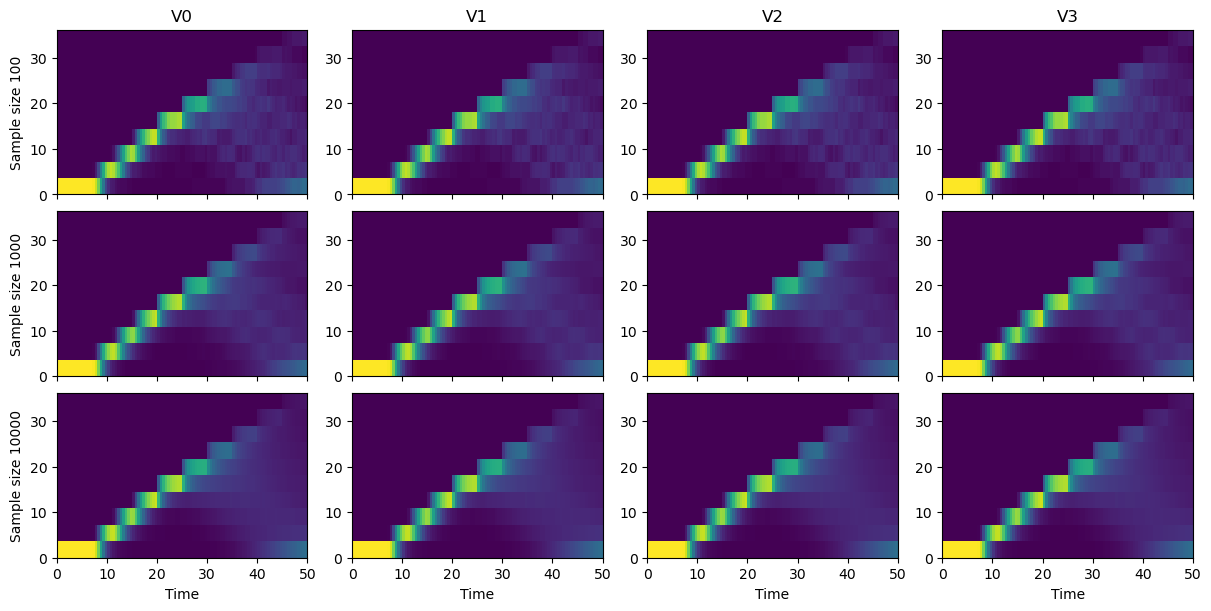

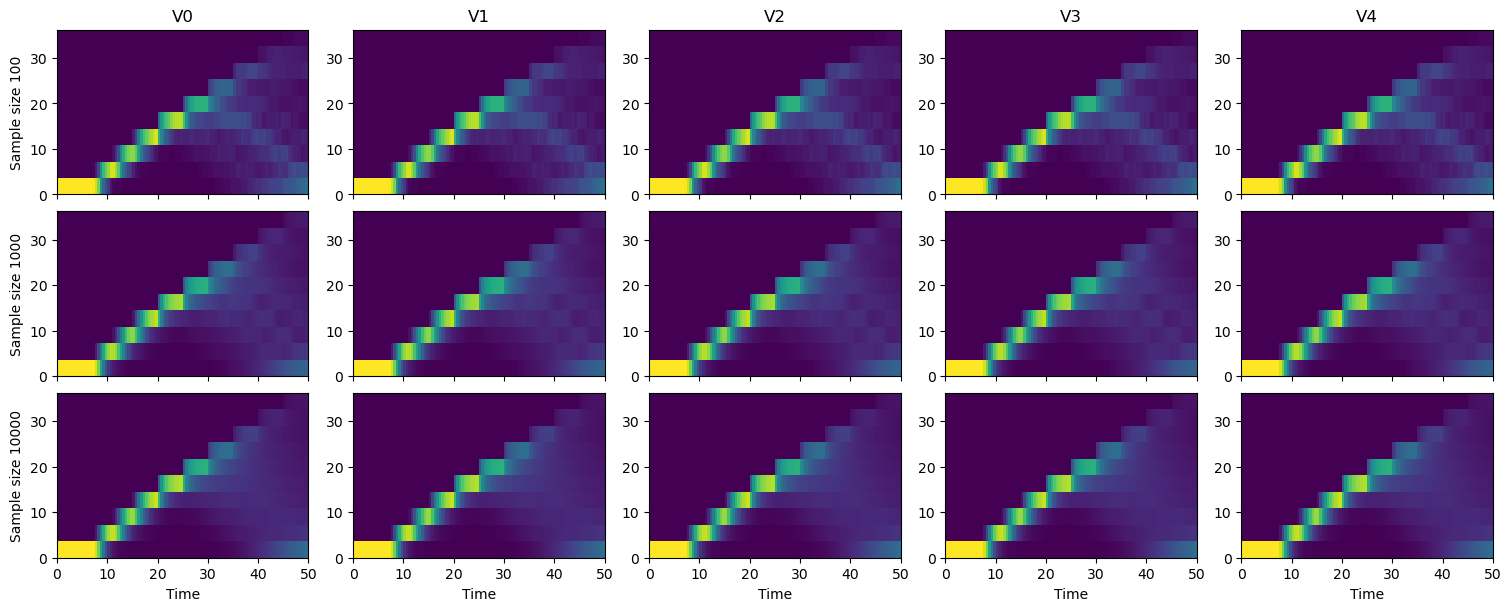

In [5]:
for i, test in enumerate(tests):
    if model_sizes[i] < 10:
        _ = test.plot_distributions()

In [6]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)


for i, test in enumerate(tests):
    label.value = f'Test: {i+1}... '

    label.value += 'Finding ECFs... '
    test.find_ecfs()
    label.value += 'Finding differences... '
    test.measure_ecf_diffs()
    label.value += 'Testing samples... '
    test.test_sampling(err_thresh=1E-3)
    label.value += 'Generating fits... '
    test.generate_ecf_sampling_fits()
_ = out.clear_output()

Output()

/home/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:994: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


Show sensitivity to model size.

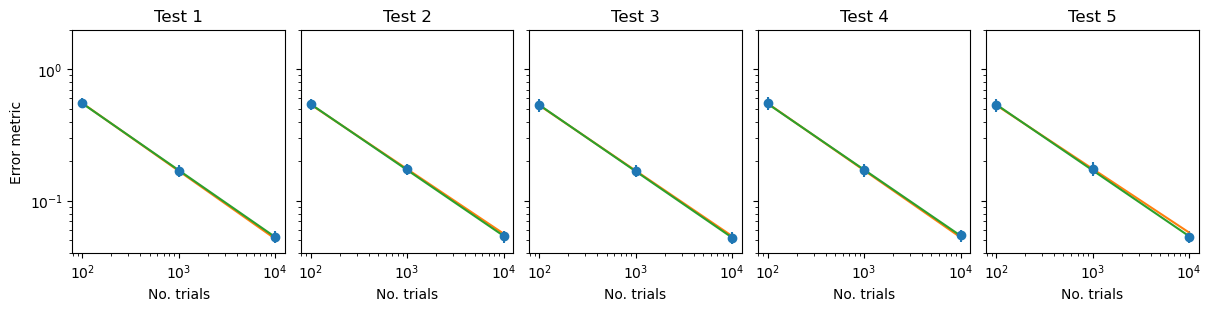

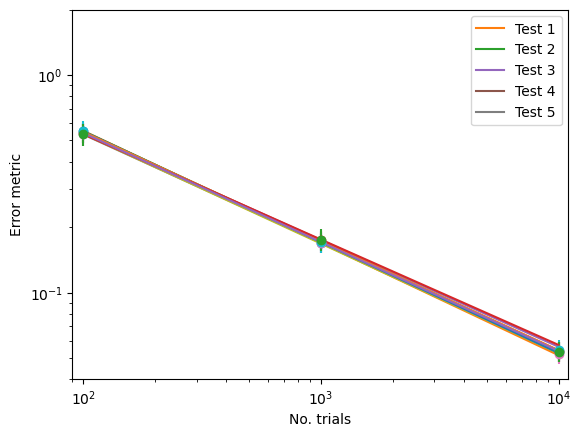

In [7]:
def plot_ecf_sampling(test, ax):
    avg = np.asarray([test.ecf_sampling[t][0] for t in test.trials], dtype=float)
    std = np.asarray([test.ecf_sampling[t][1] for t in test.trials], dtype=float)
    ax.errorbar(test.trials, avg, yerr=std, marker='o', linestyle='none')
    ax.set_xlabel('No. trials')
    ax.set_xscale('log')
    ax.set_yscale('log')

    return ax


fig, axs = plt.subplots(1, len(tests), figsize=(12.0, 3.0), layout='compressed', sharey=True)

for i, test in enumerate(tests):
    _, ax = test.plot_ecf_sampling_fits((fig, plot_ecf_sampling(test, axs[i])))
    ax.set_title(f'Test {i+1}')
    ax.set_ylim(4E-2, 2.0)
_ = axs[0].set_ylabel('Error metric')

fig, axs = plt.subplots(1, 1)
for test in tests:
    test.plot_ecf_sampling_fits((fig, plot_ecf_sampling(test, axs)))
axs.set_xlim(min(tests[0].trials) * 0.9, max(tests[1].trials) * 1.1)
axs.set_ylim(4E-2, 2.0)
axs.legend(labels=[f'Test {i+1}' for i in range(len(tests))])
_ = axs.set_ylabel('Error metric')

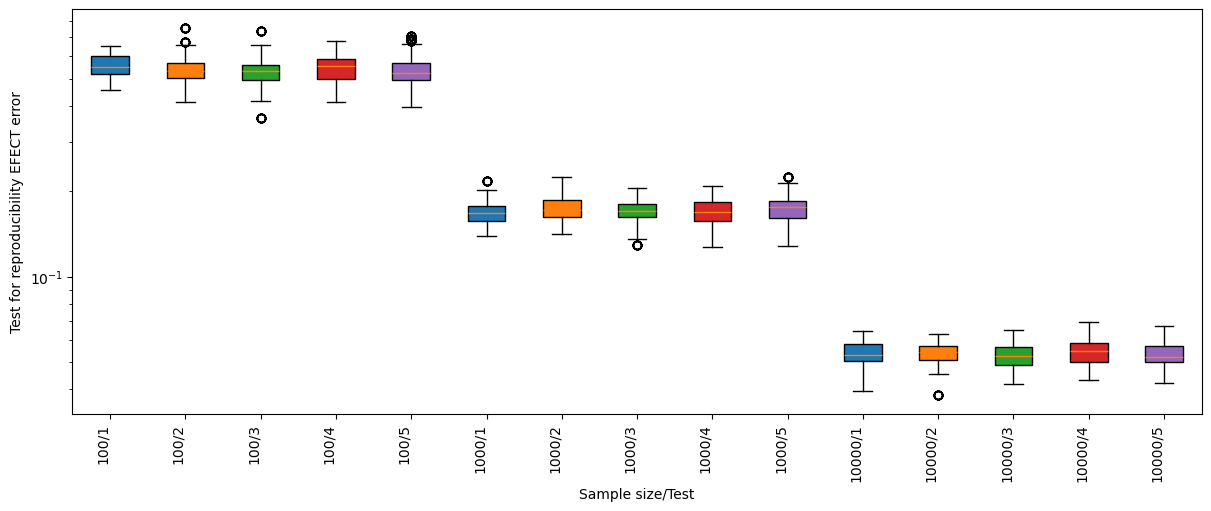

In [8]:
fig_ax = plt.subplots(1, 1, figsize=(12.0, 5.0), layout='compressed')

data = []
labels = []
for t in test_kwargs['trials']:
    for i, test in enumerate(tests):
        data.append(test.ks_stats_sampling[t])
        labels.append(f'{t}/{i+1}')

bplot = fig_ax[1].boxplot(data, labels=labels, vert=True, patch_artist=True)
fig_ax[1].set_yscale('log')
fig_ax[1].set_xlabel('Sample size/Test')
fig_ax[1].set_ylabel('Test for reproducibility EFECT error')
fig_ax[1].set_xticklabels(fig_ax[1].get_xticklabels(), rotation=90, ha='right')

color_names = list(mcolors.TABLEAU_COLORS)
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(color_names[i % len(tests)])

In [9]:
for i in range(len(tests)):
    fp = f'proto_compare_size_1_{i+1}.json'
    print('Saving output:', fp)
    tests[i].save(fp)
fp_summary = 'proto_compare_size_1_inputs.json'
print('Outputting summary:', fp_summary)
with open(fp_summary, 'w') as f:
    output_data = dict(
        rate=rate,
        stdev_cf=stdev_cf,
        mag={f'proto_compare_size_1_{i+1}.json': model_sizes[i] for i in range(len(model_sizes))}
    )
    json.dump(output_data, f, indent=4)

Saving output: proto_compare_size_1_1.json


Saving output: proto_compare_size_1_2.json


Saving output: proto_compare_size_1_3.json


Saving output: proto_compare_size_1_4.json


Saving output: proto_compare_size_1_5.json


Outputting summary: proto_compare_size_1_inputs.json
